In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import pyglstudy as gl
from pyglstudy.group_lasso import *
from pyglstudy.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy
from tqdm import tqdm

In [3]:
def analyze_base(out):
    diag = out['diagnostic']

    if out['error'] != '':
        logging.warning(out['error'])

    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")
    
    gl_diag = diag['time_group_lasso']
    time_strong = [np.sum(d['time_strong_cd']) for d in gl_diag]
    time_active = [np.sum(d['time_active_cd']) for d in gl_diag]
    logging.debug(f"Time Strong Total:  {np.sum(time_strong)}")
    logging.debug(f"Time Active Total:  {np.sum(time_active)}")

    logging.debug(f"Number of lambdas:  {len(out['lmdas'])}")

def analyze_cov(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(out):
    analyze_base(out)
    
    diag = out['diagnostic']
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Loop Number")
            ax.set_ylabel("Time (s)")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    axes[0].plot(diag['n_cds'], marker='.')
    axes[0].set_title("Number of CDs")
    axes[0].set_xlabel("Basil Iteration")
    axes[0].set_ylabel("Number of CDs")
    axes[1].plot(-np.log(out['lmdas']), out['rsqs'], marker='.')
    axes[1].set_title("$R^2$")
    axes[1].set_xlabel("$-\\log(\\lambda)$")
    axes[1].set_ylabel("$R^2$")
    plt.show()

    _, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
    active_count = [out['betas'][:, j].count_nonzero() for j in range(out['betas'].shape[-1])]
    axes[0].plot(active_count, marker='.')
    axes[0].set_title("Active Count")
    axes[0].set_xlabel("$\\lambda$ index")
    axes[0].set_ylabel("Active count")

    axes[1].plot(out['diagnostic']['strong_sizes_total'], marker='.')
    axes[1].set_title("Strong Count")
    axes[1].set_xlabel("$\\lambda$ index")
    axes[1].set_ylabel("Strong count")
    plt.show()
    
    _, axes = plt.subplots(1, 1, layout='constrained', figsize=(10, 4))
    for j in tqdm(range(out['betas'].shape[0])):
        beta_j = out['betas'][j]
        if beta_j.count_nonzero() > 0:
            axes.plot(-np.log(out['lmdas']), beta_j.todense().reshape((-1,1)))
    axes.set_title('Non-zero $\\beta$ Profile')
    axes.set_xlabel('$-\log(\lambda)$')
    axes.set_ylabel('$\\beta$')
    plt.show()


In [4]:
n = 10
p = 1000
n_groups = int(p/100)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=-0.1, svd_transform=False, group_split_type="random",
).values()

In [5]:
alpha = 1
penalty = np.sqrt(group_sizes)

In [6]:
# naive
out_naive = group_basil(
    X, y, groups, group_sizes, 
    alpha=alpha,
    penalty=penalty,
    method='naive', 
    max_n_cds=int(1e5), 
    n_lambdas_iter=5,
    #use_strong_rule=False,
    use_strong_rule=True,
    max_strong_size=p,
    verbose_diagnostic=True,
    do_early_exit=False,
)
diag_naive = out_naive['diagnostic']

  6.32967  -1.81847   7.98942   4.10897  -3.84808   3.29401 -0.269298   3.37367   7.52247   3.22976
===
0 0 0 0 0 0 0 0 0 0
===
0 0 0 0 0 0 0 0 0 0
===
0 0 0 0 0 0 0 0 0 0
===
 0.00336213 -0.00251552   0.0258004   0.0337998 -0.00198849   0.0329966   0.0598291  -0.0540519   0.0179744  -0.0236624
===
nan nan nan nan nan nan nan nan nan nan
===
0 0 0 0 0 0 0 0 0 0
===
 0.00386564 -0.00289224   0.0296642   0.0388615 -0.00228628    0.037938   0.0687889  -0.0621466   0.0206662   -0.027206
===
nan nan nan nan nan nan nan nan nan nan
===
0 0 0 0 0 0 0 0 0 0
===
 0.00444454 -0.00332538   0.0341066   0.0446813 -0.00262866   0.0436195   0.0790905  -0.0714534   0.0237611  -0.0312803
===
nan nan nan nan nan nan nan nan nan nan
===
0 0 0 0 0 0 0 0 0 0
===
 0.00511014 -0.00382337   0.0392143   0.0513726 -0.00302232   0.0501518   0.0909349  -0.0821541   0.0273195  -0.0359647
===
nan nan nan nan nan nan nan nan nan nan
===
0 0 0 0 0 0 0 0 0 0
===
 0.00587542 -0.00439595    0.045087    0.059066 -0.00347

DEBUG:root:Time Init:          4.6167e-05
DEBUG:root:Time Init Fit:      4.9458e-05
DEBUG:root:Time Screen:        0.0037937050000000005
DEBUG:root:Time Fit:           3.9881999999999995e-05
DEBUG:root:Time KKT:           0.005587665
DEBUG:root:Time Transform:     0.0007652080000000001
DEBUG:root:Time Untransform:   1.6959e-05
DEBUG:root:Time Strong Total:  2.7110000000000004e-06
DEBUG:root:Time Active Total:  0.0
DEBUG:root:Number of lambdas:  100
100%|██████████| 34/34 [00:00<00:00, 3841.35it/s]


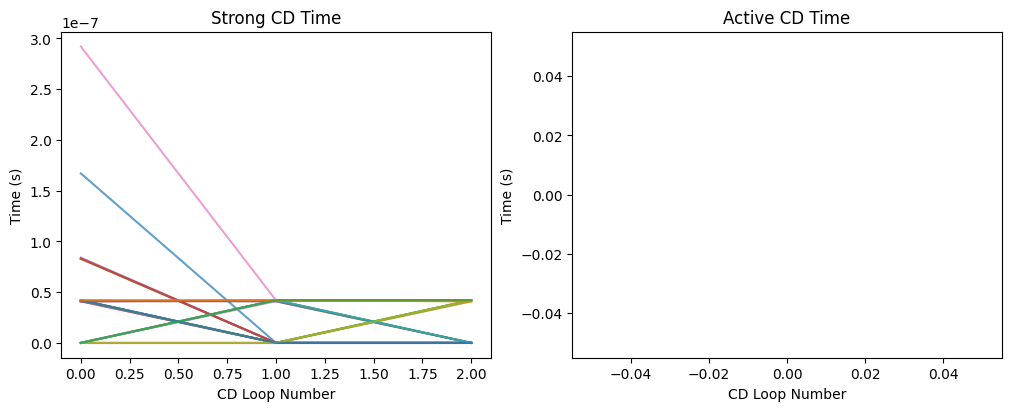

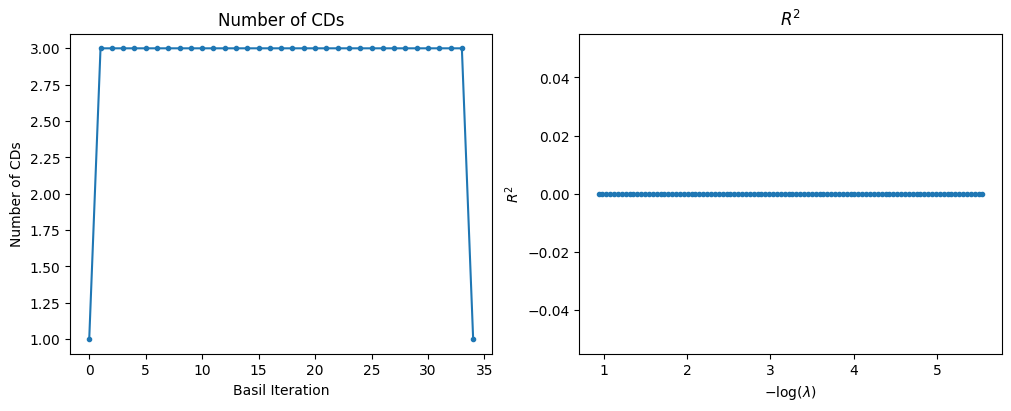

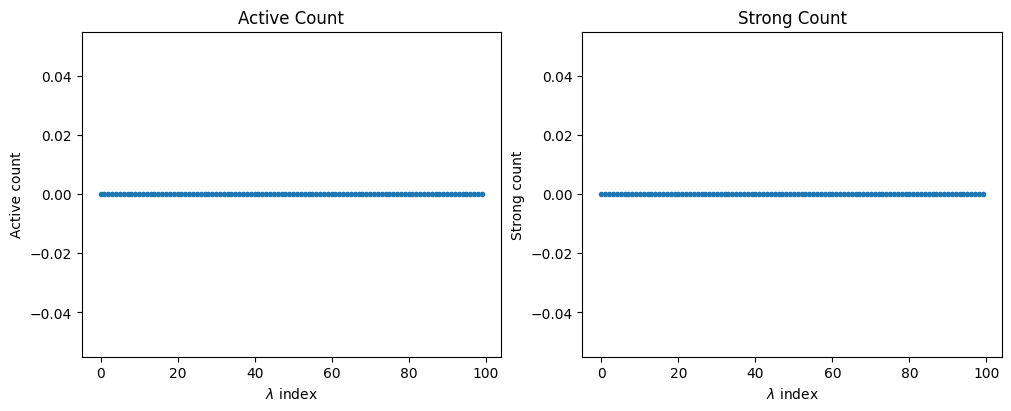

100%|██████████| 1000/1000 [00:00<00:00, 26552.78it/s]


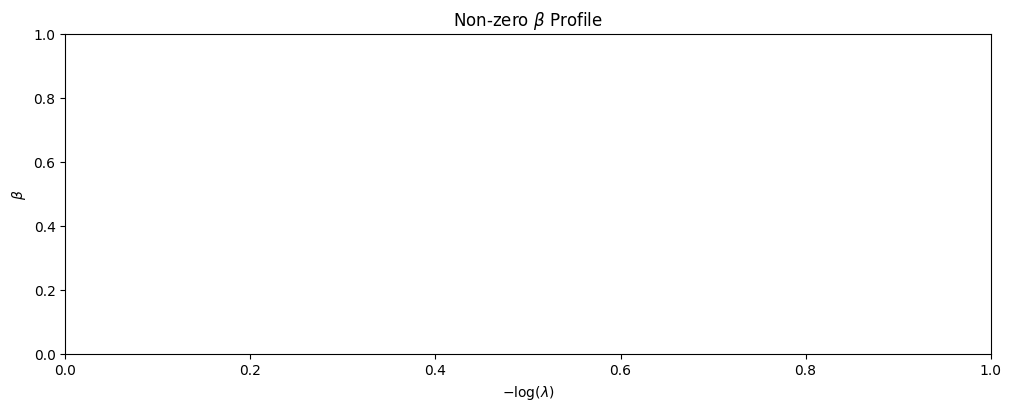

In [7]:
analyze_naive(out_naive)

In [8]:
def compute_abs_grad(
    X, y, groups, group_sizes, beta, lmda, alpha, penalty
):
    if isinstance(beta, scipy.sparse._csc.csc_matrix):
        beta = np.ravel(beta.todense())
    grad = X.T @ (y - X @ beta) - lmda * (1 - alpha) * np.repeat(penalty, group_sizes) * beta
    abs_grad = np.array([
        np.linalg.norm(grad[g:g+gs])
        for g, gs in zip(groups, group_sizes)
    ])
    return abs_grad

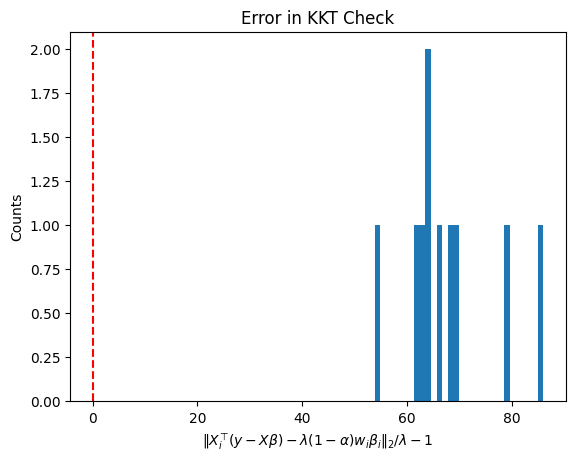

In [9]:
i = -4
beta = out_naive['betas'][:, i]
lmda = out_naive['lmdas'][i]
abs_grad = compute_abs_grad(X,y,groups,group_sizes,beta,lmda,alpha,penalty)
abs_grad_scaled = abs_grad / (lmda * alpha * penalty)
abs_grad_scaled = abs_grad_scaled[abs_grad_scaled > 1]
plt.hist(abs_grad_scaled-1, bins=30)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("$\|X_i^\\top (y-X\\beta) - \lambda (1-\\alpha) w_i \\beta_i\|_2 / \lambda - 1$")
plt.ylabel("Counts")
plt.title("Error in KKT Check")
plt.show()

In [21]:
def group_edpp(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    grad = X.T @ y
    abs_grad = np.array([
        np.linalg.norm(grad[g : g + gs]) / pg
        for g, gs, pg in zip(groups, group_sizes, penalty)
    ])
    i_star = np.argmax(abs_grad)
    X_star = X[:, groups[i_star] : groups[i_star] + group_sizes[i_star]]

    X_norms = np.array([
        np.linalg.norm(X[:, g : g + gs])
        for g, gs in zip(groups, group_sizes)
    ])
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]

        theta_k = (y - X @ b_k) / lmda_k
        v1_k = y / lmda_k - theta_k if k > 0 else X_star @ (X_star.T @ y)
        v2_k = y / lmda_k1 - theta_k
        v1_k_norm = np.linalg.norm(v1_k)
        v2_k_perp = v2_k - (v1_k @ v2_k) / (v1_k_norm ** 2) * v1_k
        print(v1_k)
        print(v2_k)
        print(v2_k_perp)
        grad = X.T @ (theta_k + 0.5 * v2_k_perp)
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        
        thresh = penalty - 0.5 * np.linalg.norm(v2_k_perp) * X_norms
        
        n_rejects[k] = np.sum(abs_grad <= thresh)
        
    return n_rejects
    
def group_ssr(
    X, y, groups, group_sizes, betas, lmdas, alpha, penalty
):
    assert betas.shape[-1] == lmdas.shape[-1]
    assert alpha == 1

    n_checks = lmdas.shape[-1]-1
    
    n_rejects = np.zeros(n_checks)

    for k in range(n_checks):
        b_k = np.ravel(betas[:, k].todense())
        lmda_k = lmdas[k]
        lmda_k1 = lmdas[k+1]
        
        grad = X.T @ (y - X @ b_k) - lmda_k * (1 - alpha) * np.repeat(penalty, group_sizes) * b_k
        abs_grad = np.array([
            np.linalg.norm(grad[g:g+gs])
            for g, gs in zip(groups, group_sizes)
        ])
        n_rejects[k] = np.sum(abs_grad / (alpha * penalty) <= (2 * lmda_k1 - lmda_k))
        
    return n_rejects

In [11]:
out_edpp = group_edpp(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

out_ssr = group_ssr(
    X, y, groups, group_sizes, 
    out_naive['betas'],
    np.array(out_naive['lmdas']),
    alpha,
    penalty,
)

print(out_edpp)
print(out_ssr)

[8. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[8. 8. 8. 6. 5. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


/var/folders/8w/87ph5tkx60vc7f4l87071knc0000gn/T/ipykernel_7391/1896548453.py:33: RuntimeWarning: invalid value encountered in scalar divide
  v2_k_perp = v2_k - (v1_k @ v2_k) / (v1_k_norm ** 2) * v1_k


In [22]:
group_edpp(X, y, groups, group_sizes, out_naive['betas'][:, :2], np.array(out_naive['lmdas'][:2]), alpha, penalty)

[ 6.3296685  -1.81846841  7.98942189  4.10896734 -3.84807903  3.29401319
 -0.26929818  3.3736715   7.52247059  3.22976087]
[ 0.00306345 -0.00229205  0.02350838  0.03079707 -0.00181183  0.03006523
  0.05451402 -0.04925008  0.01637762 -0.02156029]
[-0.0057192   0.00023114  0.01242276  0.02509573  0.00352752  0.02549467
  0.05488768 -0.05393117  0.00593991 -0.02604171]


array([8.])

In [12]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)
    regul = 0
    for i in range(len(groups)):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm2 = cp.norm2(beta[gb:ge])
        regul += penalty[i] * (alpha * bi_norm2 + (1-alpha) / 2 * cp.sum_squares(beta[gb:ge]))
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * regul)
    prob = cp.Problem(objective)
    result = prob.solve()
    return beta.value 


In [188]:
n_lmdas = 50
lmdas = np.array(out_naive['lmdas'][:n_lmdas])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=1, penalty=np.sqrt(group_sizes), lmda=lmdas[i])

100%|██████████| 50/50 [00:02<00:00, 20.82it/s]


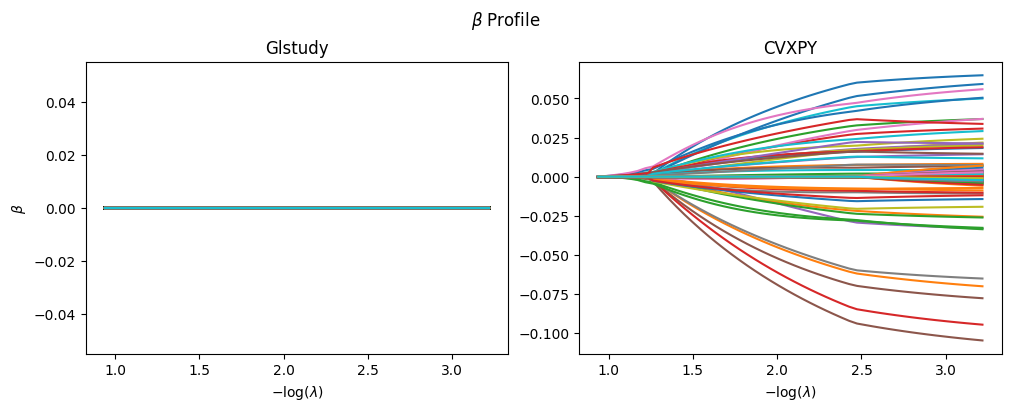

In [189]:
_, axes = plt.subplots(1, 2, layout='compressed', figsize=(10, 4))
for j in range(cvxpy_betas.shape[0]):
    beta_j = out_naive['betas'][j, :n_lmdas]
    axes[0].plot(-np.log(lmdas), beta_j.todense().reshape((-1,1)))
    axes[0].set_title('Glstudy')
    axes[0].set_ylabel('$\\beta$')
    axes[0].set_xlabel('$-\log(\lambda)$')
    axes[1].plot(-np.log(lmdas), cvxpy_betas[j])
    axes[1].set_title('CVXPY')
    axes[1].set_xlabel('$-\log(\lambda)$')
plt.suptitle('$\\beta$ Profile')
plt.show()

100%|██████████| 50/50 [00:00<00:00, 9760.10it/s]


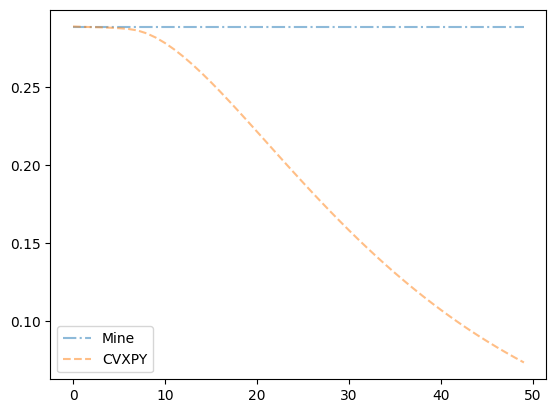

In [190]:
my_objs = np.zeros(len(lmdas))
cvxpy_objs = np.zeros(len(lmdas))
for i in tqdm(range(len(lmdas))):
    lmda = lmdas[i]
    my_objs[i] = gl.objective_data(X, y, groups, group_sizes, alpha, penalty, lmda, out_naive['betas'][:, i].todense())
    cvxpy_objs[i] = gl.objective_data(X, y, groups, group_sizes, alpha, penalty, lmda, cvxpy_betas[:, i].ravel())
plt.plot(my_objs, alpha=0.5, label="Mine", linestyle='-.')
plt.plot(cvxpy_objs, alpha=0.5, label="CVXPY", linestyle='--')
plt.legend()
plt.show()

-1.9802538145151167


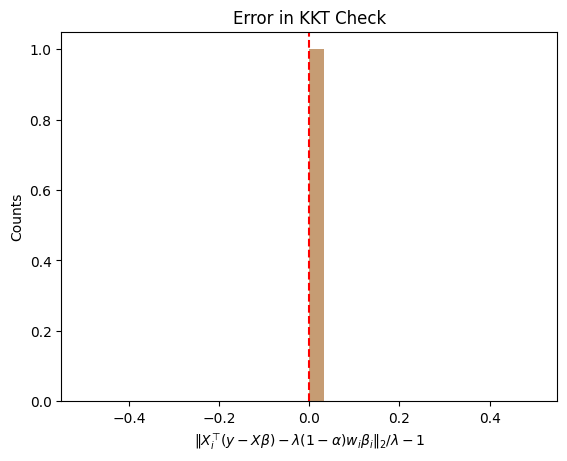

In [156]:
i = 20
print(-np.log(lmdas[i]))
beta = out_naive['betas'][:, i]
beta_cvxpy = cvxpy_betas[:, i]
lmda = lmdas[i]
abs_grad = compute_abs_grad(X,y,groups,group_sizes,beta,lmda,alpha,penalty)
abs_grad_cvxpy = compute_abs_grad(X,y,groups,group_sizes,beta_cvxpy,lmda,alpha,penalty)
abs_grad_scaled = abs_grad / (lmda * alpha * penalty)
abs_grad_scaled = abs_grad_scaled[abs_grad_scaled > 1]
abs_grad_scaled_cvxpy = abs_grad_cvxpy / (lmda * alpha * penalty)
abs_grad_scaled_cvxpy = abs_grad_scaled_cvxpy[abs_grad_scaled_cvxpy > 1]
plt.hist(abs_grad_scaled-1, bins=30, alpha=0.5)
plt.hist(abs_grad_scaled_cvxpy-1, bins=30, alpha=0.5)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("$\|X_i^\\top (y-X\\beta) - \lambda (1-\\alpha) w_i \\beta_i\|_2 / \lambda - 1$")
plt.ylabel("Counts")
plt.title("Error in KKT Check")
plt.show()

In [72]:
np.array(out_naive['betas'][:, 1].todense())[:, 0], cvxpy_betas[34:, 1], groups

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

In [20]:
out_naive['lmdas'][:2]

[8.473209268520437, 8.08808883023893]

In [192]:
out_naive['diagnostic']['checkpoints']

[{'is_initialized': True,
  'edpp_safe_set': [],
  'strong_set': [],
  'strong_g1': [],
  'strong_g2': [],
  'strong_begins': [],
  'strong_order': [],
  'strong_beta': [],
  'strong_grad': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0